In [12]:
#import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import shutil
import torch


In [2]:
base_path_train = "./MURA-v1.1/train"
print(os.path.abspath(base_path_train))

base_path_test = "./MURA-v1.1/test"
print(os.path.abspath(base_path_test))

c:\Users\jacob\OneDrive\Documents\GitHub\xray_classification_application\MURA-v1.1\train
c:\Users\jacob\OneDrive\Documents\GitHub\xray_classification_application\MURA-v1.1\test


# CNN

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import csv
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
#from torchvision import datasets

## Custom Dataset for Nested Structure of MURA

In [83]:
import os
import shutil

def restructure_mura(base_path, output_path):
    # Define train/valid directories
    for split in ["train", "valid"]:
        input_dir = os.path.join(base_path, split)
        output_dir = os.path.join(output_path, split)

        # Create positive and negative folders
        pos_dir = os.path.join(output_dir, "positive")
        neg_dir = os.path.join(output_dir, "negative")
        os.makedirs(pos_dir, exist_ok=True)
        os.makedirs(neg_dir, exist_ok=True)

        # Iterate through modality folders (e.g., XR_WRIST, XR_ELBOW, etc.)
        for modality in os.listdir(input_dir):
            modality_path = os.path.join(input_dir, modality)
            if os.path.isdir(modality_path):
                for patient in os.listdir(modality_path):
                    patient_path = os.path.join(modality_path, patient)
                    if os.path.isdir(patient_path):
                        for study in os.listdir(patient_path):
                            study_path = os.path.join(patient_path, study)
                            if os.path.isdir(study_path):
                                # Determine if study is positive or negative
                                if "positive" in study:
                                    target_folder = pos_dir
                                else:
                                    target_folder = neg_dir
                                
                                # Move all images into corresponding class folder
                                for image in os.listdir(study_path):
                                    image_path = os.path.join(study_path, image)
                                    new_image_path = os.path.join(target_folder, f"{patient}_{study}_{image}")
                                    
                                    if not os.path.exists(new_image_path):  # Avoid overwriting
                                        shutil.copy2(image_path, new_image_path)  

    print(f"MURA dataset successfully restructured in: {output_path}")

# Example Usage
base_path = "MURA-v1.1"
output_path = "path_to_restructured_MURA"
restructure_mura(base_path, output_path)


MURA dataset successfully restructured in: path_to_restructured_MURA


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except (FileNotFoundError, OSError):
            print(f"Skipping corrupt image at index {index}")
            return self.__getitem__((index + 1) % len(self))  # Move to next image

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),

])

train_dataset = SafeImageFolder(root="path_to_restructured_MURA/train", transform=transform)
valid_dataset = SafeImageFolder(root="path_to_restructured_MURA/valid", transform=transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
test_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


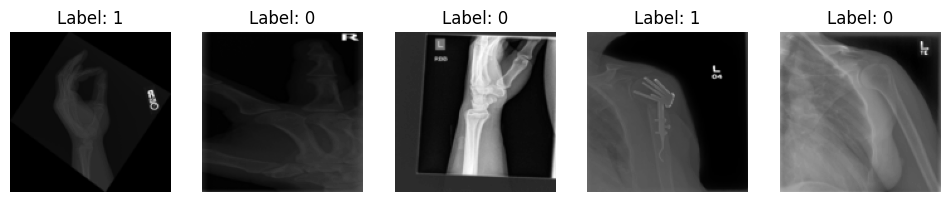

In [13]:
# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)
#for image in images:
    #print(image.shape)

# Plot first 5 images
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0).squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")
plt.show()

In [14]:
# Example to iterate through the DataLoader
for images, labels in train_loader:
    print(f"Batch Image Shape: {images.shape}, Batch Labels Shape: {labels.shape}")
    break

Batch Image Shape: torch.Size([32, 1, 128, 128]), Batch Labels Shape: torch.Size([32])


# Building CNN

In [15]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

from tqdm import tqdm 

In [16]:
import torch
import torch.nn as nn

class MURA_CNN(nn.Module):
    def __init__(self, num_classes): #num_classes will depend on the MURA task
        super(MURA_CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves the spatial dimensions

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves again

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves again

        # Calculate the flattened size after pooling
        self.flattened_size = 64 * 16 * 16  # 128 / 2 / 2 / 2 = 16

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes) #Output layer.

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        x = x.view(-1, self.flattened_size)  # Flatten the tensor
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Example Usage:
num_classes = 2 #binary classification example.
model = MURA_CNN(num_classes)
input_tensor = torch.randn(1, 1, 128, 128)  # Example input
output = model(input_tensor)
print(output.shape)

torch.Size([1, 2])


In [17]:
num_classes = 2  # Replace with the number of classes in your MURA task
model = MURA_CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10


In [18]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Evaluation on the test set
    model.eval() #set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) #get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total} %')

print("Finished Training")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.6635857712063524


 10%|█         | 1/10 [04:26<39:57, 266.39s/it]

Accuracy of the network on the test images: 54.247660187185026 %
Epoch 2/10, Loss: 0.6435717108624953


 20%|██        | 2/10 [08:21<33:05, 248.24s/it]

Accuracy of the network on the test images: 56.8394528437725 %
Epoch 3/10, Loss: 0.6224293965432379


 30%|███       | 3/10 [12:17<28:17, 242.46s/it]

Accuracy of the network on the test images: 59.50323974082073 %
Epoch 4/10, Loss: 0.5921146239119547


 40%|████      | 4/10 [16:14<24:00, 240.11s/it]

Accuracy of the network on the test images: 62.706983441324695 %
Epoch 5/10, Loss: 0.5452703461050987


 50%|█████     | 5/10 [20:10<19:54, 238.97s/it]

Accuracy of the network on the test images: 61.98704103671706 %
Epoch 6/10, Loss: 0.48653861262180187


 60%|██████    | 6/10 [24:06<15:51, 237.88s/it]

Accuracy of the network on the test images: 61.98704103671706 %
Epoch 7/10, Loss: 0.4062432129625921


 70%|███████   | 7/10 [28:02<11:51, 237.19s/it]

Accuracy of the network on the test images: 62.05903527717783 %
Epoch 8/10, Loss: 0.31459826519367873


 80%|████████  | 8/10 [31:58<07:53, 236.91s/it]

Accuracy of the network on the test images: 60.22318214542837 %
Epoch 9/10, Loss: 0.2276138731899361


 90%|█████████ | 9/10 [35:54<03:56, 236.69s/it]

Accuracy of the network on the test images: 60.69114470842332 %
Epoch 10/10, Loss: 0.15592929613776504


100%|██████████| 10/10 [39:50<00:00, 239.07s/it]

Accuracy of the network on the test images: 61.19510439164867 %
Finished Training
